In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.

set_tracking(project_name="17.LangGraph")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph]


### SubGraph 의 입력과 출력을 변환하는 방법

#### `graph` 와 `subgraph` 를 정의합니다.

다음과 같인 3개의 `graph` 를 정의합니다. 

1. `parent graph` 
2. `parent graph` 에 의해 호출될 `child graph`
3. `child graph` 에 의해 호출될 `grandchild graph`

##### 1. `grandchild graph` 를 정의합니다.

In [3]:
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START, END


# 손자 노드의 상태를 정의하는 TypedDict 클래스, 문자열 타입의 my_grandchild_key 포함
class GrandChildState(TypedDict):
    my_grandchild_key: str


# 손자 노드의 상태를 처리하는 함수, 입력된 문자열에 인사말 추가
def grandchild_1(state: GrandChildState) -> GrandChildState:
    # 자식 또는 부모 키는 여기서 접근 불가
    return {"my_grandchild_key": f'([GrandChild] {state["my_grandchild_key"]})'}


# 손자 노드의 상태 그래프 초기화
grandchild = StateGraph(GrandChildState)

# 상태 그래프에 손자 노드 추가
grandchild.add_node("grandchild_1", grandchild_1)

# 시작 노드에서 손자 노드로의 엣지 연결
grandchild.add_edge(START, "grandchild_1")

# 손자 노드에서 종료 노드로의 엣지 연결
grandchild.add_edge("grandchild_1", END)

# 정의된 상태 그래프 컴파일 및 실행 가능한 그래프 생성
grandchild_graph = grandchild.compile()

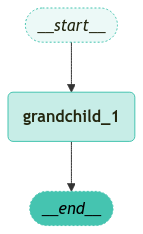

In [4]:
from graphs import visualize_graph

visualize_graph(grandchild_graph, xray=True)

In [6]:
# 그래프 호출
for chunk in grandchild_graph.stream(
    {"my_grandchild_key": "grand child KEY"}, subgraphs=True
):
    print(chunk)

((), {'grandchild_1': {'my_grandchild_key': '([GrandChild] grand child KEY)'}})


##### 2. `child graph` 를 정의합니다.

In [7]:
# 자식 상태 타입 정의를 위한 TypedDict 클래스
class ChildState(TypedDict):
    my_child_key: str


# 손자 그래프 호출 및 상태 변환 함수, 자식 상태를 입력받아 변환된 자식 상태 반환
def call_grandchild_graph(state: ChildState) -> ChildState:
    # 참고: 부모 또는 손자 키는 여기서 접근 불가능
    # 자식 상태 채널에서 손자 상태 채널로 상태 변환
    grandchild_graph_input = {"my_grandchild_key": state["my_child_key"]}
    # 손자 상태 채널에서 자식 상태 채널로 상태 변환 후 결과 반환
    grandchild_graph_output = grandchild_graph.invoke(grandchild_graph_input)
    return {"my_child_key": f'([Child] {grandchild_graph_output["my_grandchild_key"]})'}


# 자식 상태 그래프 초기화
child = StateGraph(ChildState)
# 참고: 컴파일된 그래프 대신 함수 전달
# 자식 그래프에 노드 추가 및 시작-종료 엣지 연결
child.add_node("child_1", call_grandchild_graph)
child.add_edge(START, "child_1")
child.add_edge("child_1", END)
# 자식 그래프 컴파일
child_graph = child.compile()

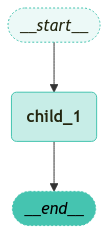

In [9]:
visualize_graph(child_graph, xray=True)

In [11]:
# child_graph 그래프 호출
for chunk in child_graph.stream({"my_child_key": "child KEY"}, subgraphs=True):
    print(chunk)

(('child_1:ffbd7e54-ebeb-49b9-1b6d-7108d0763453',), {'grandchild_1': {'my_grandchild_key': '([GrandChild] child KEY)'}})
((), {'child_1': {'my_child_key': '([Child] ([GrandChild] child KEY))'}})


grandchild_graph의 호출을 별도의 함수(call_grandchild_graph)로 감싸고 있습니다.  
  
이 함수는 grandchild 그래프를 호출하기 전에 입력 상태를 변환하고, grandchild 그래프의 출력을 다시 child 그래프 상태로 변환합니다.  
  
만약 이러한 변환 없이 grandchild_graph를 직접 .add_node에 전달하면, child와 grandchild 상태 간에 공유된 상태 키(State Key) 이 없기 때문에 LangGraph에서 오류가 발생하게 됩니다.
  
중요  
  
child subgraph 와 grandchild subgraph는 parent graph와 공유되지 않는 자신만의 독립적인 state를 가지고 있다는 점에 유의하시기 바랍니다.  

##### 3. `parent graph` 를 정의합니다.

In [13]:
# 부모 상태 타입 정의를 위한 TypedDict 클래스
class ParentState(TypedDict):
    my_parent_key: str


# 부모 상태의 my_parent_key 값에 '[Parent1]' 문자열을 추가하는 변환 함수
def parent_1(state: ParentState) -> ParentState:
    # 참고: 자식 또는 손자 키는 여기서 접근 불가
    return {"my_parent_key": f'([Parent1] {state["my_parent_key"]})'}


# 부모 상태의 my_parent_key 값에 '[Parent2]' 문자열을 추가하는 변환 함수
def parent_2(state: ParentState) -> ParentState:
    return {"my_parent_key": f'([Parent2] {state["my_parent_key"]})'}


# 부모 상태와 자식 상태 간의 데이터 변환 및 자식 그래프 호출 처리
def call_child_graph(state: ParentState) -> ParentState:
    # 부모 상태 채널(my_parent_key)에서 자식 상태 채널(my_child_key)로 상태 변환
    child_graph_input = {"my_child_key": state["my_parent_key"]}
    # 자식 상태 채널(my_child_key)에서 부모 상태 채널(my_parent_key)로 상태 변환
    child_graph_output = child_graph.invoke(child_graph_input)
    return {"my_parent_key": child_graph_output["my_child_key"]}


# 부모 상태 그래프 초기화 및 노드 구성
parent = StateGraph(ParentState)
parent.add_node("parent_1", parent_1)

# 참고: 컴파일된 그래프가 아닌 함수를 전달
parent.add_node("child", call_child_graph)
parent.add_node("parent_2", parent_2)

# 상태 그래프의 실행 흐름을 정의하는 엣지 구성
parent.add_edge(START, "parent_1")
parent.add_edge("parent_1", "child")
parent.add_edge("child", "parent_2")
parent.add_edge("parent_2", END)

# 구성된 부모 상태 그래프의 컴파일 및 실행 가능한 그래프 생성
parent_graph = parent.compile()

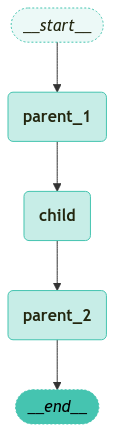

In [14]:
visualize_graph(parent_graph, xray=True)

In [15]:
for chunk in parent_graph.stream({"my_parent_key": "Parent!"}, subgraphs=True):
    print(chunk)

((), {'parent_1': {'my_parent_key': '([Parent1] Parent!)'}})
(('child:26ff54b5-ce86-4fc1-a928-7b241232805f', 'child_1:5db4aa90-c81b-f2a5-9bbc-41f134338873'), {'grandchild_1': {'my_grandchild_key': '([GrandChild] ([Parent1] Parent!))'}})
(('child:26ff54b5-ce86-4fc1-a928-7b241232805f',), {'child_1': {'my_child_key': '([Child] ([GrandChild] ([Parent1] Parent!)))'}})
((), {'child': {'my_parent_key': '([Child] ([GrandChild] ([Parent1] Parent!)))'}})
((), {'parent_2': {'my_parent_key': '([Parent2] ([Child] ([GrandChild] ([Parent1] Parent!))))'}})
